## Reference mapping with scvi-tools

This tutorial covers the usage of the [scArches method](https://www.biorxiv.org/content/10.1101/2020.07.16.205997v1) with SCVI, SCANVI, and TOTALVI. 

This particular workflow is useful in the case where a model is trained on some data (called reference here) and new samples are received (called query). The goal is to analyze these samples in the context of the reference, by mapping the query cells to the same reference latent space. This workflow may also be used in the [scarches](https://scarches.readthedocs.io/) package, but here we demonstrate using only scvi-tools.

### Imports and scvi-tools installation (colab)

In [1]:
%%capture
import sys

# If True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

if IN_COLAB:
    !pip install --quiet scrublet

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import anndata
import scvi
import scanpy as sc

sc.set_figure_params(figsize=(4, 4))
scvi.settings.seed = 94705

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Global seed set to 0
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
Global seed set to 94705


### Online update of SCVI

Here we use the pancreas dataset described in the [scIB](https://github.com/theislab/scib) manuscript, that is also widely used to benchmark integration methods.

In [3]:
url = "https://figshare.com/ndownloader/files/24539828"
adata = sc.read("pancreas.h5ad", backup_url=url)
print(adata)

  0%|          | 0.00/301M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


In [4]:
adata.obs.tech.value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

We consider the SS2 and CelSeq2 samples as query, and all the others as reference.

In [5]:
query = np.array([s in ["smartseq2", "celseq2"] for s in adata.obs.tech])

adata_ref = adata[~query].copy()
adata_query = adata[query].copy()

We run highly variable gene selection on the reference data and use these same genes for the query data.

In [6]:
sc.pp.highly_variable_genes(
    adata_ref, 
    n_top_genes=2000, 
    batch_key="tech", 
    subset=True
)

adata_query = adata_query[:, adata_ref.var_names].copy()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Train reference

We train the reference using the standard SCVI workflow, except we add a few non-default parameters that were identified to work well with scArches.

In [7]:
scvi.model.SCVI.setup_anndata(adata_ref, batch_key="tech", layer="counts")

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [8]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
    encode_covariates=True,
    dropout_rate=0.2,
    n_layers=2,
)

vae_ref = scvi.model.SCVI(
    adata_ref, 
    **arches_params
)
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 400/400: 100%|██████████| 400/400 [06:05<00:00,  1.09it/s, loss=768, v_num=1]


Now we obtain the latent representation, and use Scanpy to visualize with UMAP.

In [10]:
adata_ref.obsm["X_scVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

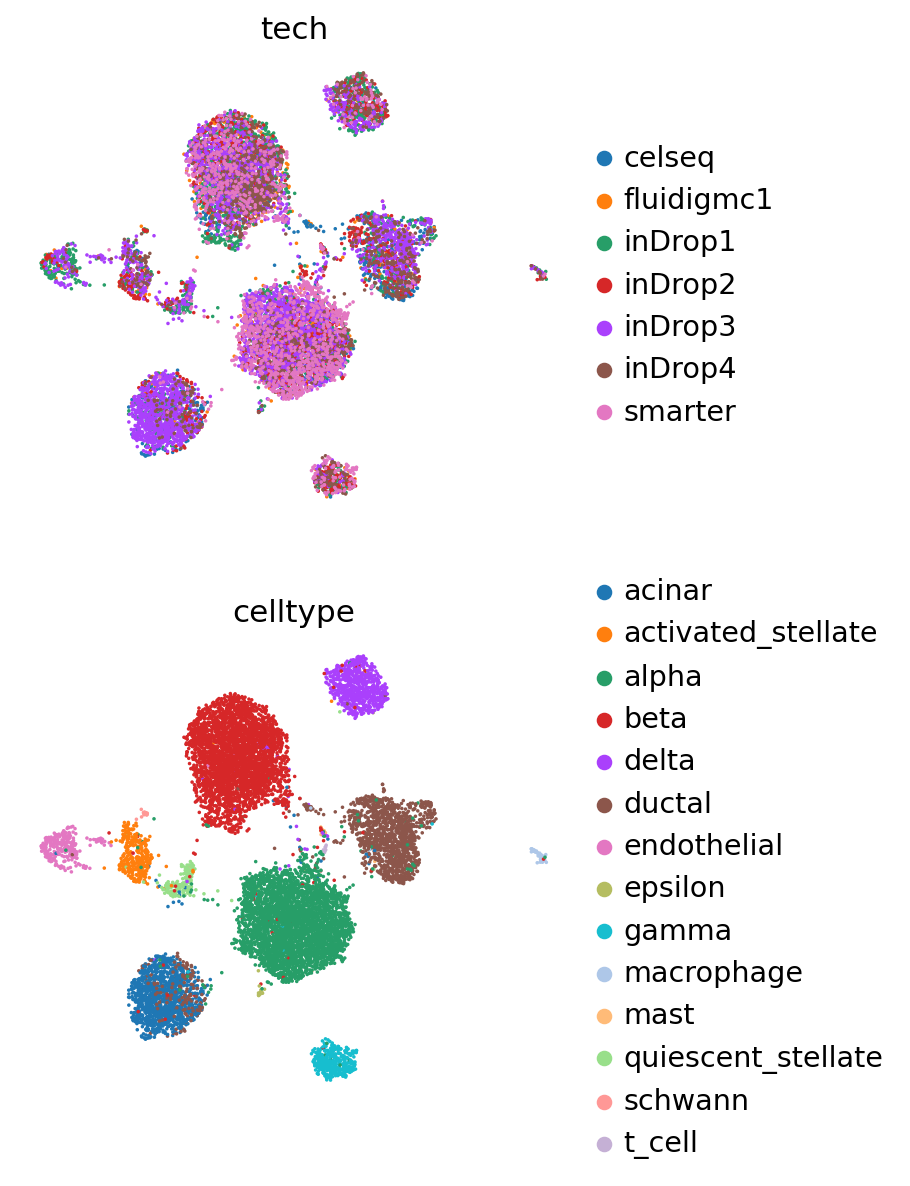

In [11]:
sc.pl.umap(
    adata_ref, 
    color=["tech", "celltype"], 
    frameon=False, 
    ncols=1, 
)

#### Online update with query

We can load a new model with the query data either using 

1. The saved reference model
2. The instantiation of the reference model in memory

In [12]:
# save the reference model
dir_path = "pancreas_model/"
vae_ref.save(dir_path, overwrite=True)

In [13]:
# both are valid
vae_q = scvi.model.SCVI.load_query_data(
    adata_query, 
    dir_path, 
)
vae_q = scvi.model.SCVI.load_query_data(
    adata_query, 
    vae_ref, 
)

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
/usr/local/lib/python3.7/dist-packages/scvi/model/base/_archesmixin.py:124: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"


This is a typical `SCVI` object, and after training, can be used in any defined way.

For training the query data, we recommend using a `weight_decay` of 0.0. This ensures the latent representation of the reference cells will remain exactly the same if passing them through this new query model.

In [14]:
vae_q.train(max_epochs=200, plan_kwargs=dict(weight_decay=0.0))
adata_query.obsm["X_scVI"] = vae_q.get_latent_representation()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 200/200: 100%|██████████| 200/200 [01:12<00:00,  2.78it/s, loss=1.74e+03, v_num=1]


In [15]:
sc.pp.neighbors(adata_query, use_rep="X_scVI")
sc.tl.leiden(adata_query)
sc.tl.umap(adata_query)

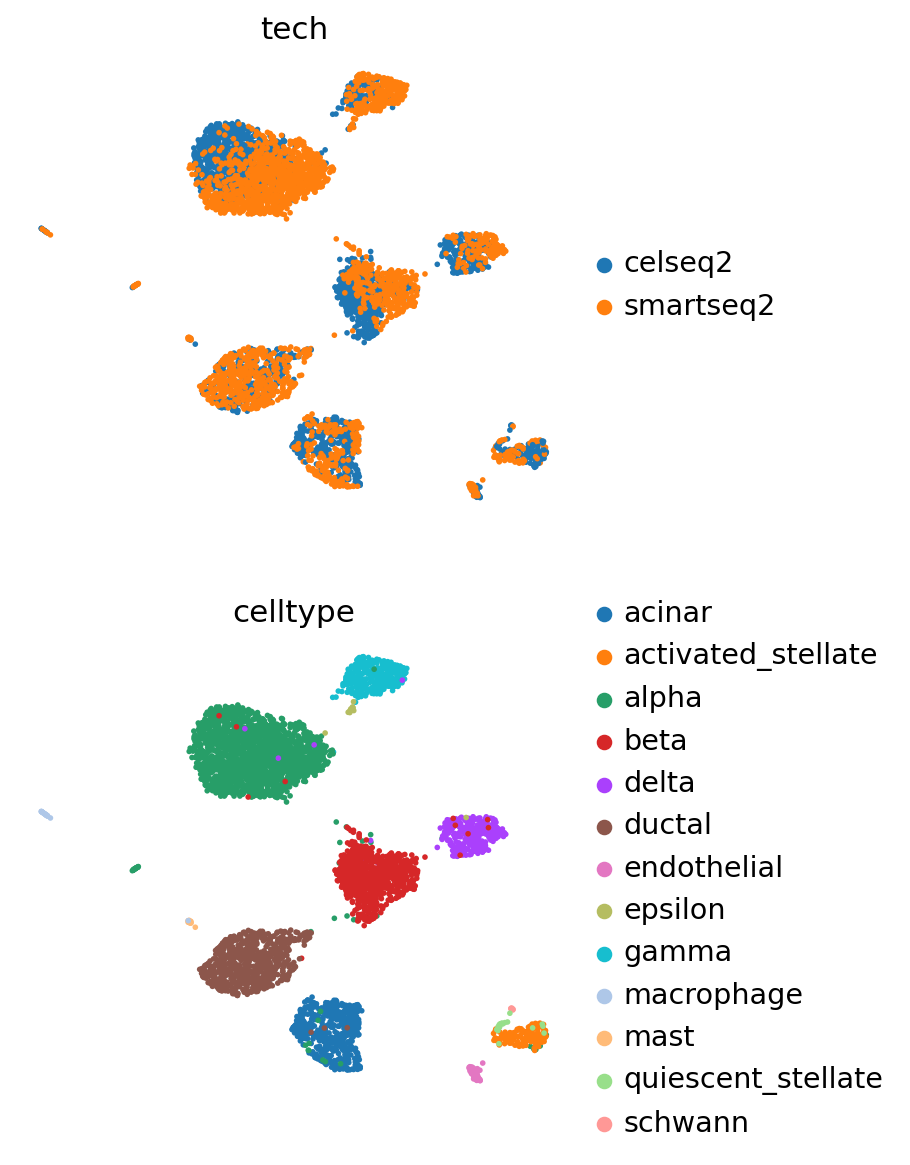

In [16]:
sc.pl.umap(
    adata_query, 
    color=["tech", "celltype"], 
    frameon=False, 
    ncols=1, 
)

#### Visualize reference and query

In [17]:
adata_full = adata_query.concatenate(adata_ref)

The concatenated object has the latent representations of both reference and query, but we are also able to reobtain these values using the query model.

In [18]:
adata_full.obsm["X_scVI"] = vae_q.get_latent_representation(adata_full)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


In [19]:
sc.pp.neighbors(adata_full, use_rep="X_scVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

... storing 'tech' as categorical
... storing 'celltype' as categorical


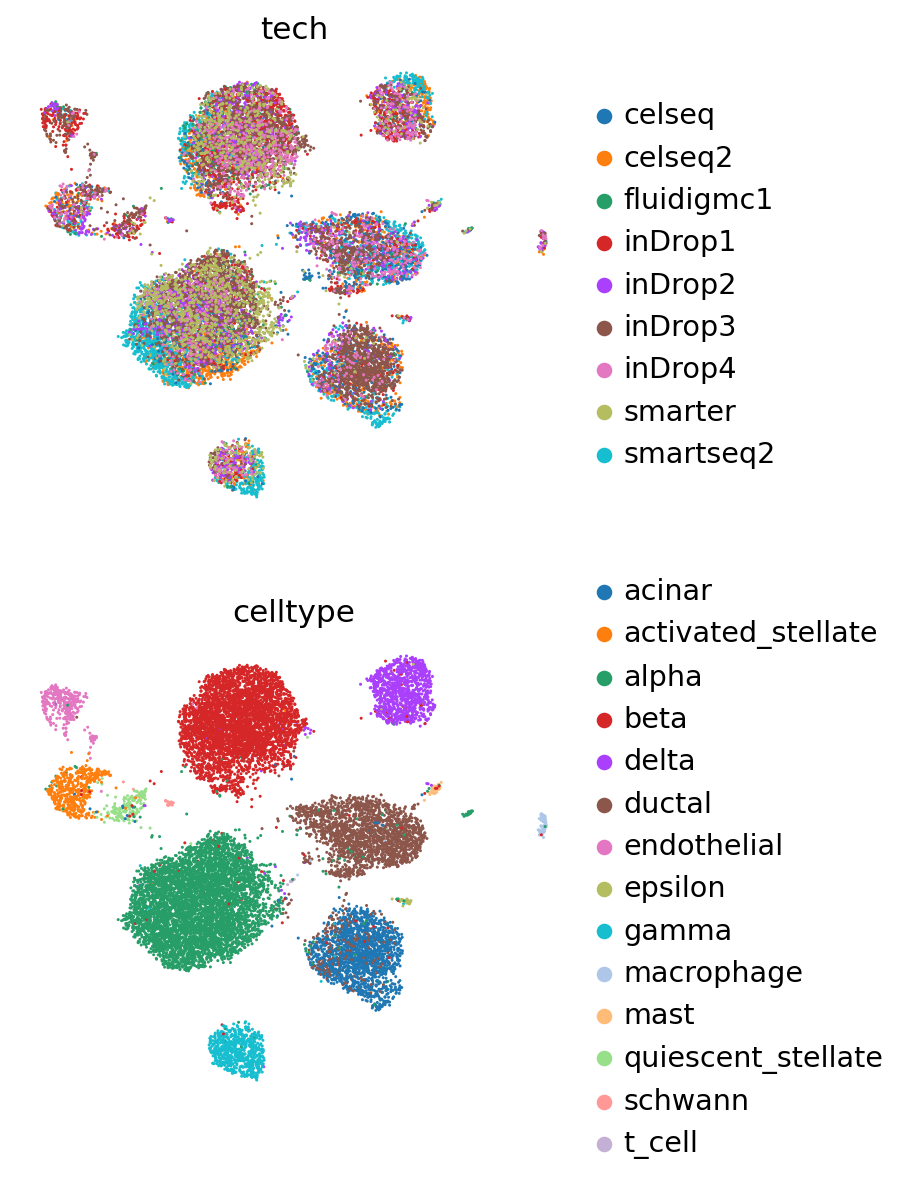

In [20]:
sc.pl.umap(
    adata_full, 
    color=["tech", "celltype"], 
    frameon=False, 
    ncols=1, 
)

### Online update of SCANVI

We'll use the same Pancreas dataset, this time we set it up such that we register that the dataset has labels.

The advantage of SCANVI is that we'll be able to predict the cell type labels of the query dataset. In the case of SCVI, a separate classifier (e.g., nearest-neighbor, random forest, etc.) would have to be trained on the reference latent space.

#### Train reference

`SCANVI` tends to perform better in situations where it has been initialized using a pre-trained `SCVI` model. In this case, we will use `vae_ref` that we have already trained above. In other words, a typical `SCANVI` workflow will be:

```python
scvi_model = SCVI(adata_ref, **arches_params)
scvi_model.train()
scanvi_model = SCANVI.from_scvi_model(scvi_model, "Unknown")
scanvi_model.train()
```

`SCANVI.from_scvi_model` will also run `setup_anndata`. It will use the `batch_key` and `layer` used with `SCVI`, but here we add the `labels_key`.

Applying this workflow in the context of this tutorial:

In [21]:
# unlabeled category does not exist in adata.obs[labels_key]
# so all cells are treated as labeled
vae_ref_scan = scvi.model.SCANVI.from_scvi_model(
    vae_ref,
    unlabeled_category="Unknown",
    labels_key="celltype",
)

In [22]:
vae_ref_scan.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                             


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 20/20: 100%|██████████| 20/20 [00:36<00:00,  1.82s/it, loss=857, v_num=1]


In [23]:
adata_ref.obsm["X_scANVI"] = vae_ref_scan.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_scANVI")
sc.tl.leiden(adata_ref)
sc.tl.umap(adata_ref)

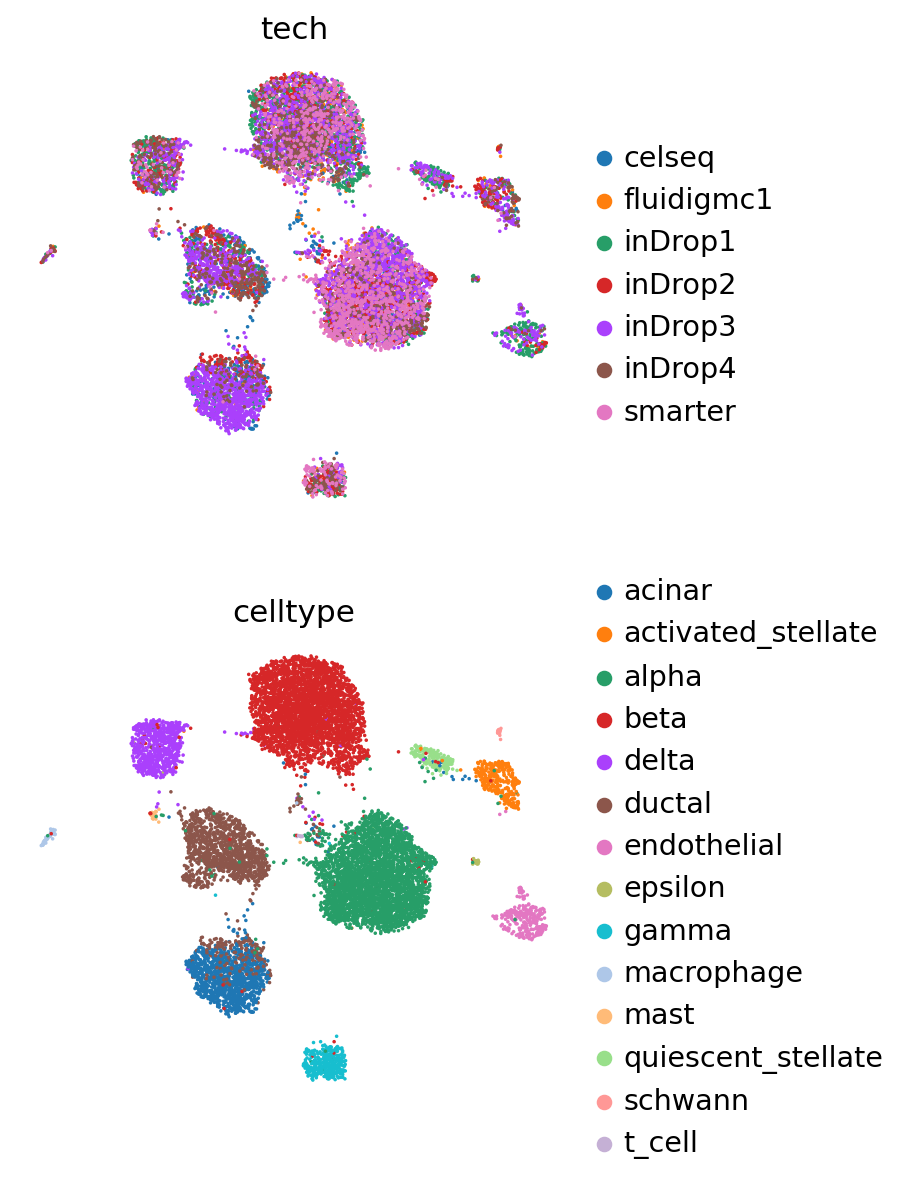

In [24]:
sc.pl.umap(
    adata_ref, 
    color=["tech", "celltype"], 
    frameon=False, 
    ncols=1, 
)

#### Online update with query

In [25]:
dir_path_scan = "pancreas_model_scanvi/"
vae_ref_scan.save(dir_path_scan, overwrite=True)

`SCANVI` is a bit trickier. Because the query data has the true cell type labels inside the anndata, we need to do something a bit hacky and tell the model which cells are labeled and which are unlabeled. We will make this cleaner in a future release. However, in most practical use cases, the query data will not have the cell types already.

In [26]:
vae_q = scvi.model.SCANVI.load_query_data(
    adata_query, 
    dir_path_scan, 
)
vae_q._unlabeled_indices = np.arange(adata_query.n_obs)
vae_q._labeled_indices = []

/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "
/usr/local/lib/python3.7/dist-packages/scvi/model/base/_archesmixin.py:124: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"


In [27]:
vae_q.train(
    max_epochs=100, 
    plan_kwargs=dict(weight_decay=0.0),
    check_val_every_n_epoch=10,
)

INFO     Training for 100 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/100:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scvi/distributions/_negative_binomial.py:435: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


Epoch 100/100: 100%|██████████| 100/100 [01:07<00:00,  1.48it/s, loss=1.85e+03, v_num=1]


In [28]:
adata_query.obsm["X_scANVI"] = vae_q.get_latent_representation()
adata_query.obs["predictions"] = vae_q.predict()

Text(0, 0.5, 'Observed')

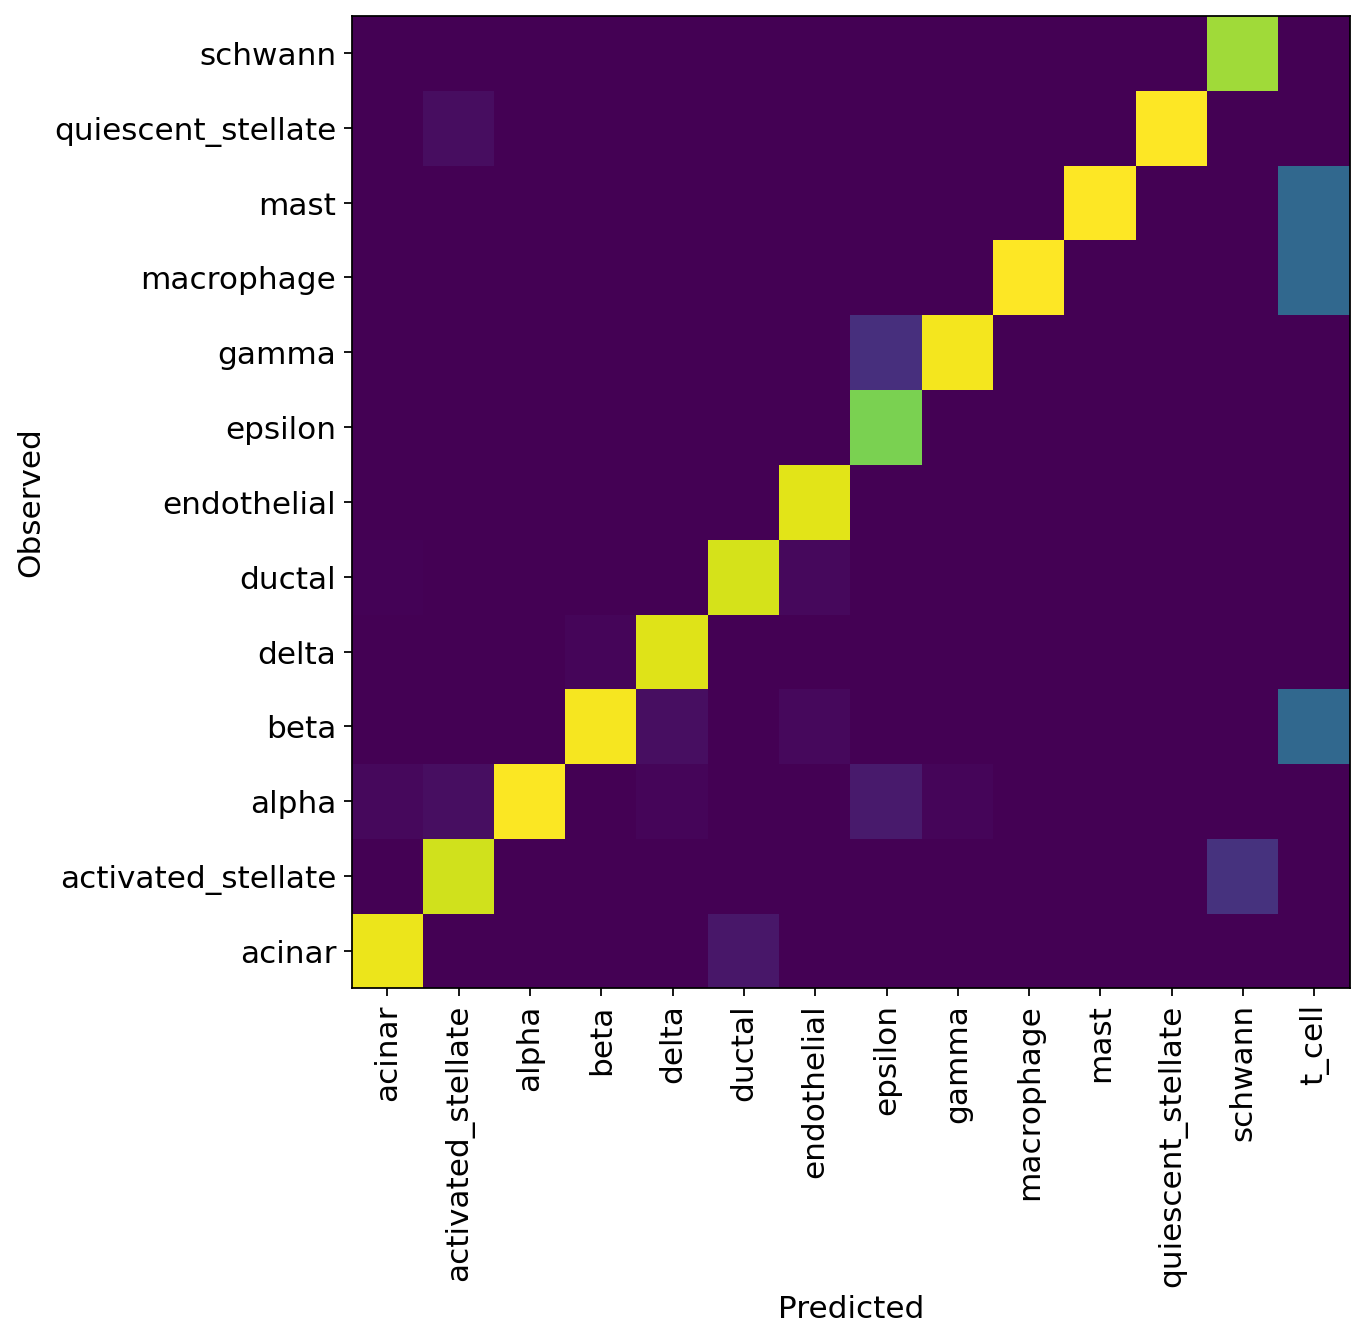

In [29]:
df = adata_query.obs.groupby(["celltype", "predictions"]).size().unstack(fill_value=0)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Predicted")
plt.ylabel("Observed")



#### Analyze reference and query

In [30]:
adata_full = adata_query.concatenate(adata_ref)

This just makes a column in the anndata corresponding to if the data come from the reference or query sets.

In [31]:
adata_full.obs.batch.cat.rename_categories(["Query", "Reference"], inplace=True)

In [32]:
full_predictions = vae_q.predict(adata_full)
print("Acc: {}".format(np.mean(full_predictions == adata_full.obs.celltype)))

adata_full.obs["predictions"] = full_predictions

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


/usr/local/lib/python3.7/dist-packages/scvi/data/fields/_layer_field.py:79: UserWarning: adata.layers[counts] does not contain unnormalized count data. Are you sure this is what you want?
  f"{logger_data_loc} does not contain unnormalized count data. "


Acc: 0.9633744353558784


In [33]:
sc.pp.neighbors(adata_full, use_rep="X_scANVI")
sc.tl.leiden(adata_full)
sc.tl.umap(adata_full)

... storing 'tech' as categorical
... storing 'celltype' as categorical
... storing 'predictions' as categorical


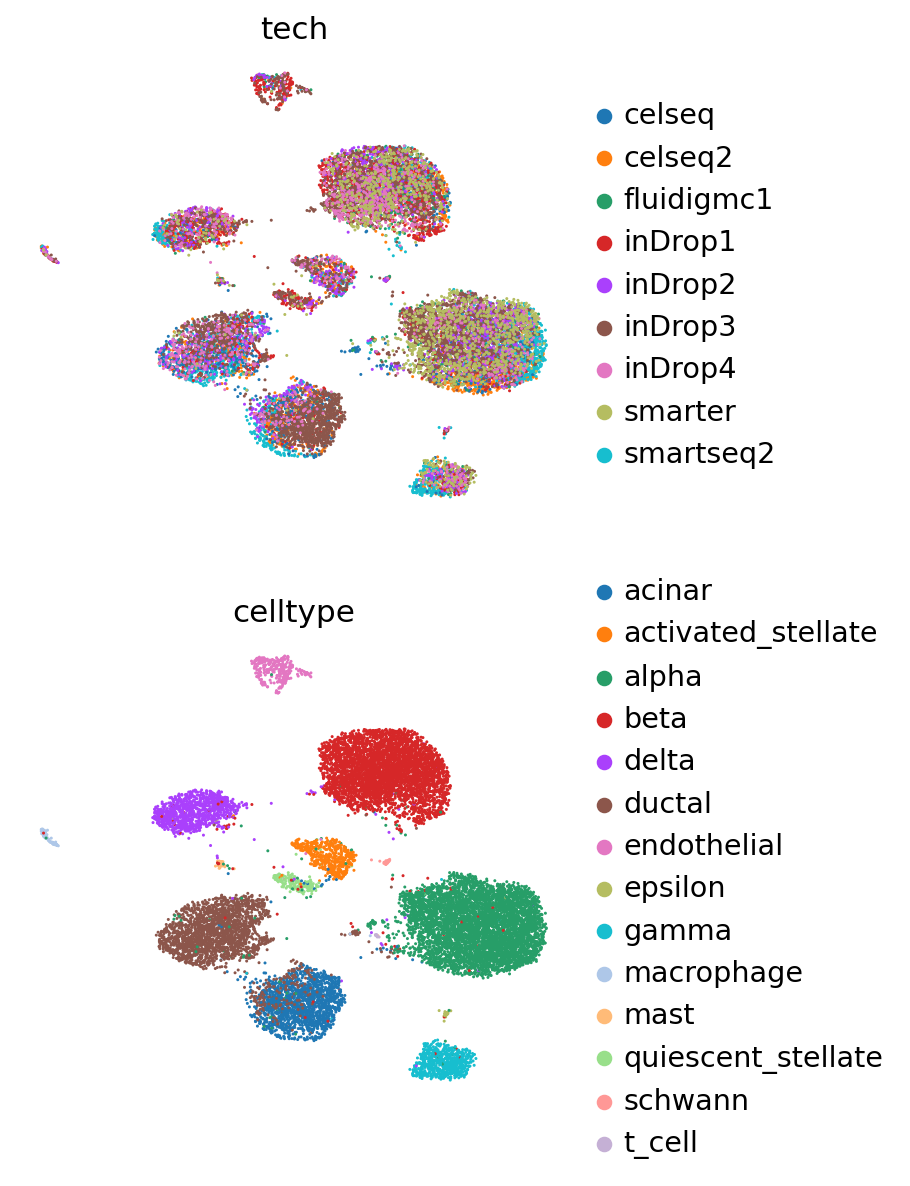

In [34]:
sc.pl.umap(
    adata_full, 
    color=["tech", "celltype"], 
    frameon=False, 
    ncols=1, 
)

Trying to set attribute `._uns` of view, copying.


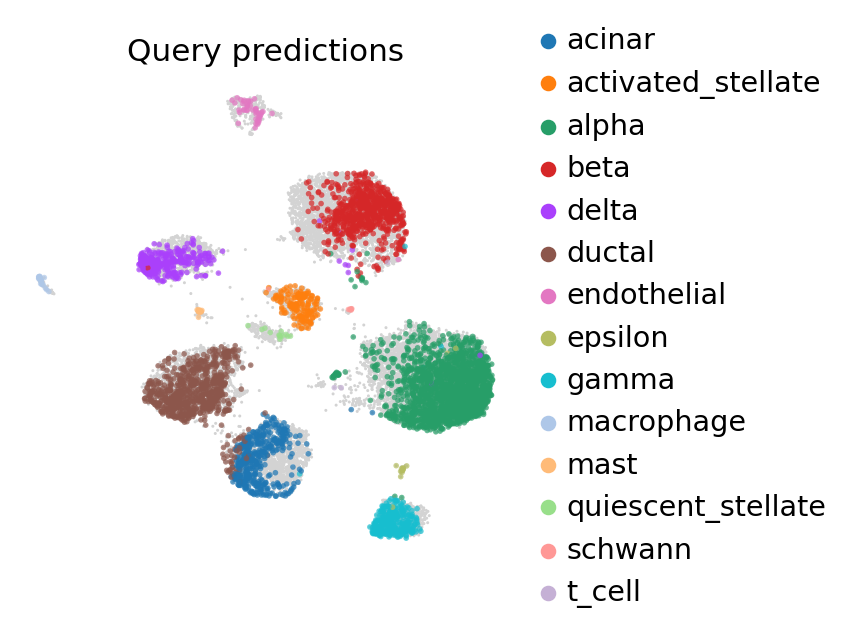

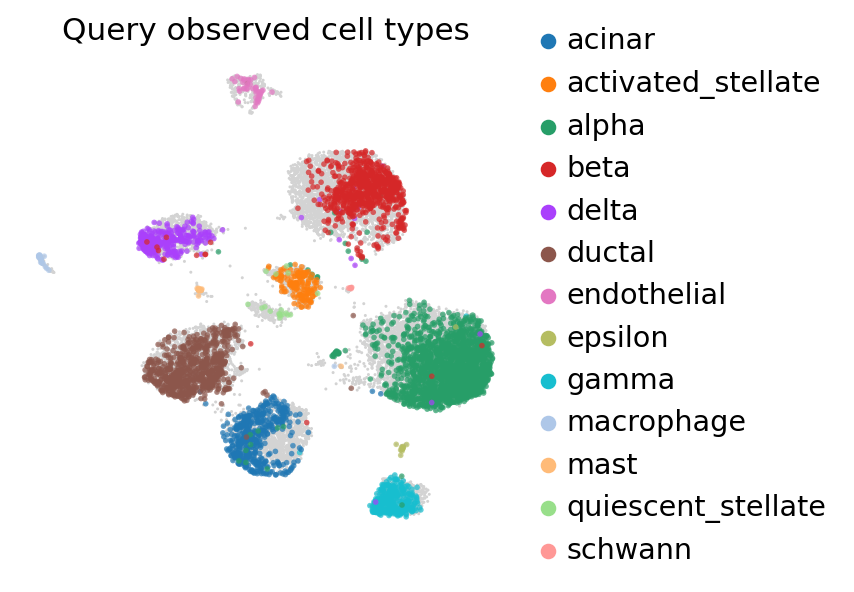

In [35]:
ax = sc.pl.umap(
    adata_full, 
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[:adata_query.n_obs], 
    color=["predictions"], 
    frameon=False, 
    title="Query predictions",
    ax=ax,
    alpha=0.7
)

ax = sc.pl.umap(
    adata_full, 
    frameon=False,
    show=False,
)
sc.pl.umap(
    adata_full[:adata_query.n_obs], 
    color=["celltype"], 
    frameon=False, 
    title="Query observed cell types",
    ax=ax,
    alpha=0.7
)

### Online update of TOTALVI

This workflow works very similarly for TOTALVI. Here we demonstrate how to build a CITE-seq reference and use scRNA-seq only data as the query.

#### Assemble data

For totalVI, we will treat two CITE-seq PBMC datasets from 10X Genomics as the reference. These datasets were already filtered for outliers like doublets, as described in the totalVI manuscript. There are 14 proteins in the reference.

In [38]:
adata_ref = scvi.data.pbmcs_10x_cite_seq()

INFO     Downloading file at data/pbmc_10k_protein_v3.h5ad                                   
Downloading...: 24938it [00:00, 118322.62it/s]                             
INFO     Downloading file at data/pbmc_5k_protein_v3.h5ad                                    
Downloading...: 100%|██████████| 18295/18295.0 [00:00<00:00, 104609.87it/s]


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In general, there will be some necessary data wrangling. For example, we need to provide totalVI with some protein data -- and when it's all zeros, totalVI identifies that the protein data is missing in this "batch".

It could have also been the case that only some of the protein data was missing, in which case we would add zeros for each of the missing proteins.

In [39]:
adata_query = scvi.data.dataset_10x("pbmc_10k_v3")
adata_query.obs["batch"] = "PBMC 10k (RNA only)"
# put matrix of zeros for protein expression (considered missing)
pro_exp = adata_ref.obsm["protein_expression"]
data = np.zeros((adata_query.n_obs, pro_exp.shape[1]))
adata_query.obsm["protein_expression"] = pd.DataFrame(columns=pro_exp.columns, index=adata_query.obs_names, data = data)

INFO     Downloading file at data/10X/pbmc_10k_v3/filtered_feature_bc_matrix.h5              
Downloading...: 37492it [00:01, 31300.10it/s]                             


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


We do some light QC filtering on the query dataset (doublets, mitochondrial, etc.)

In [40]:
import scrublet as scr
scrub = scr.Scrublet(adata_query.X)
doublet_scores, predicted_doublets = scrub.scrub_doublets()
adata_query = adata_query[~predicted_doublets].copy()

adata_query.var['mt'] = adata_query.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_query, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata_query = adata_query[adata_query.obs.pct_counts_mt < 15, :].copy()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 4.7%
Estimated detectable doublet fraction = 55.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 15.3 seconds


Now to concatenate the objects, which intersects the genes properly.

In [41]:
adata_full = anndata.concat([adata_ref, adata_query])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


And split them back up into reference and query (but now genes are properly aligned between objects).

In [42]:
adata_ref = adata_full[np.logical_or(adata_full.obs.batch == "PBMC5k", adata_full.obs.batch == "PBMC10k")].copy()
adata_query = adata_full[adata_full.obs.batch == "PBMC 10k (RNA only)"].copy()


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


We run gene selection on the reference, because that's all that will be avaialble to us at first.

In [43]:
sc.pp.highly_variable_genes(
    adata_ref,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
)

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Finally, we use these selected genes for the query dataset as well.

In [44]:
adata_query = adata_query[:, adata_ref.var_names].copy()

#### Train reference

In [45]:
scvi.model.TOTALVI.setup_anndata(
    adata_ref,
    batch_key="batch",
    protein_expression_obsm_key="protein_expression"
)

INFO     Using column names from columns of adata.obsm['protein_expression']                 


In [46]:
arches_params = dict(
    use_layer_norm="both",
    use_batch_norm="none",
)
vae_ref = scvi.model.TOTALVI(
    adata_ref, 
    **arches_params
)

INFO     Computing empirical prior initialization for protein background.                    


In [47]:
vae_ref.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [05:43<00:00,  1.16it/s, loss=1.21e+03, v_num=1]


In [48]:
adata_ref.obsm["X_totalVI"] = vae_ref.get_latent_representation()
sc.pp.neighbors(adata_ref, use_rep="X_totalVI")
sc.tl.umap(adata_ref, min_dist=0.4)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


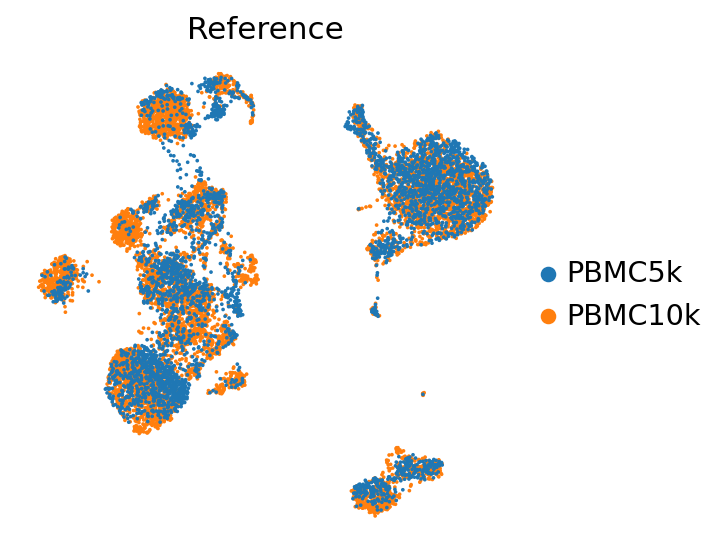

In [49]:
sc.pl.umap(
    adata_ref,
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference"
)

In [50]:
dir_path = "saved_model/"
vae_ref.save(dir_path, overwrite=True)

#### Online update with query

In [51]:
vae_q = scvi.model.TOTALVI.load_query_data(
    adata_query, 
    dir_path, 
    freeze_expression=True
)

INFO     Found batches with missing protein expression                                       
INFO     Computing empirical prior initialization for protein background.                    


/usr/local/lib/python3.7/dist-packages/scvi/model/_totalvi.py:133: UserWarning: Some proteins have all 0 counts in some batches. These proteins will be treated as missing measurements; however, this can occur due to experimental design/biology. Reinitialize the model with `override_missing_proteins=True`,to override this behavior.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/scvi/model/base/_archesmixin.py:124: UserWarning: Query integration should be performed using models trained with version >= 0.8
  "Query integration should be performed using models trained with version >= 0.8"


In [52]:
vae_q.train(200, plan_kwargs=dict(weight_decay=0.0))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 200/200: 100%|██████████| 200/200 [03:28<00:00,  1.04s/it, loss=755, v_num=1]


In [53]:
adata_query.obsm["X_totalVI"] = vae_q.get_latent_representation()
sc.pp.neighbors(adata_query, use_rep="X_totalVI")
sc.tl.umap(adata_query, min_dist=0.4)

/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

#### Impute protein data for query and visualize

Now that we have updated with the query, we can impute the proteins that were observed in the reference, using the `transform_batch` parameter.

In [54]:
_, imputed_proteins = vae_q.get_normalized_expression(
    adata_query,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

Very quickly we can identify the major expected subpopulations of B cells, CD4 T cells, CD8 T cells, monocytes, etc.

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


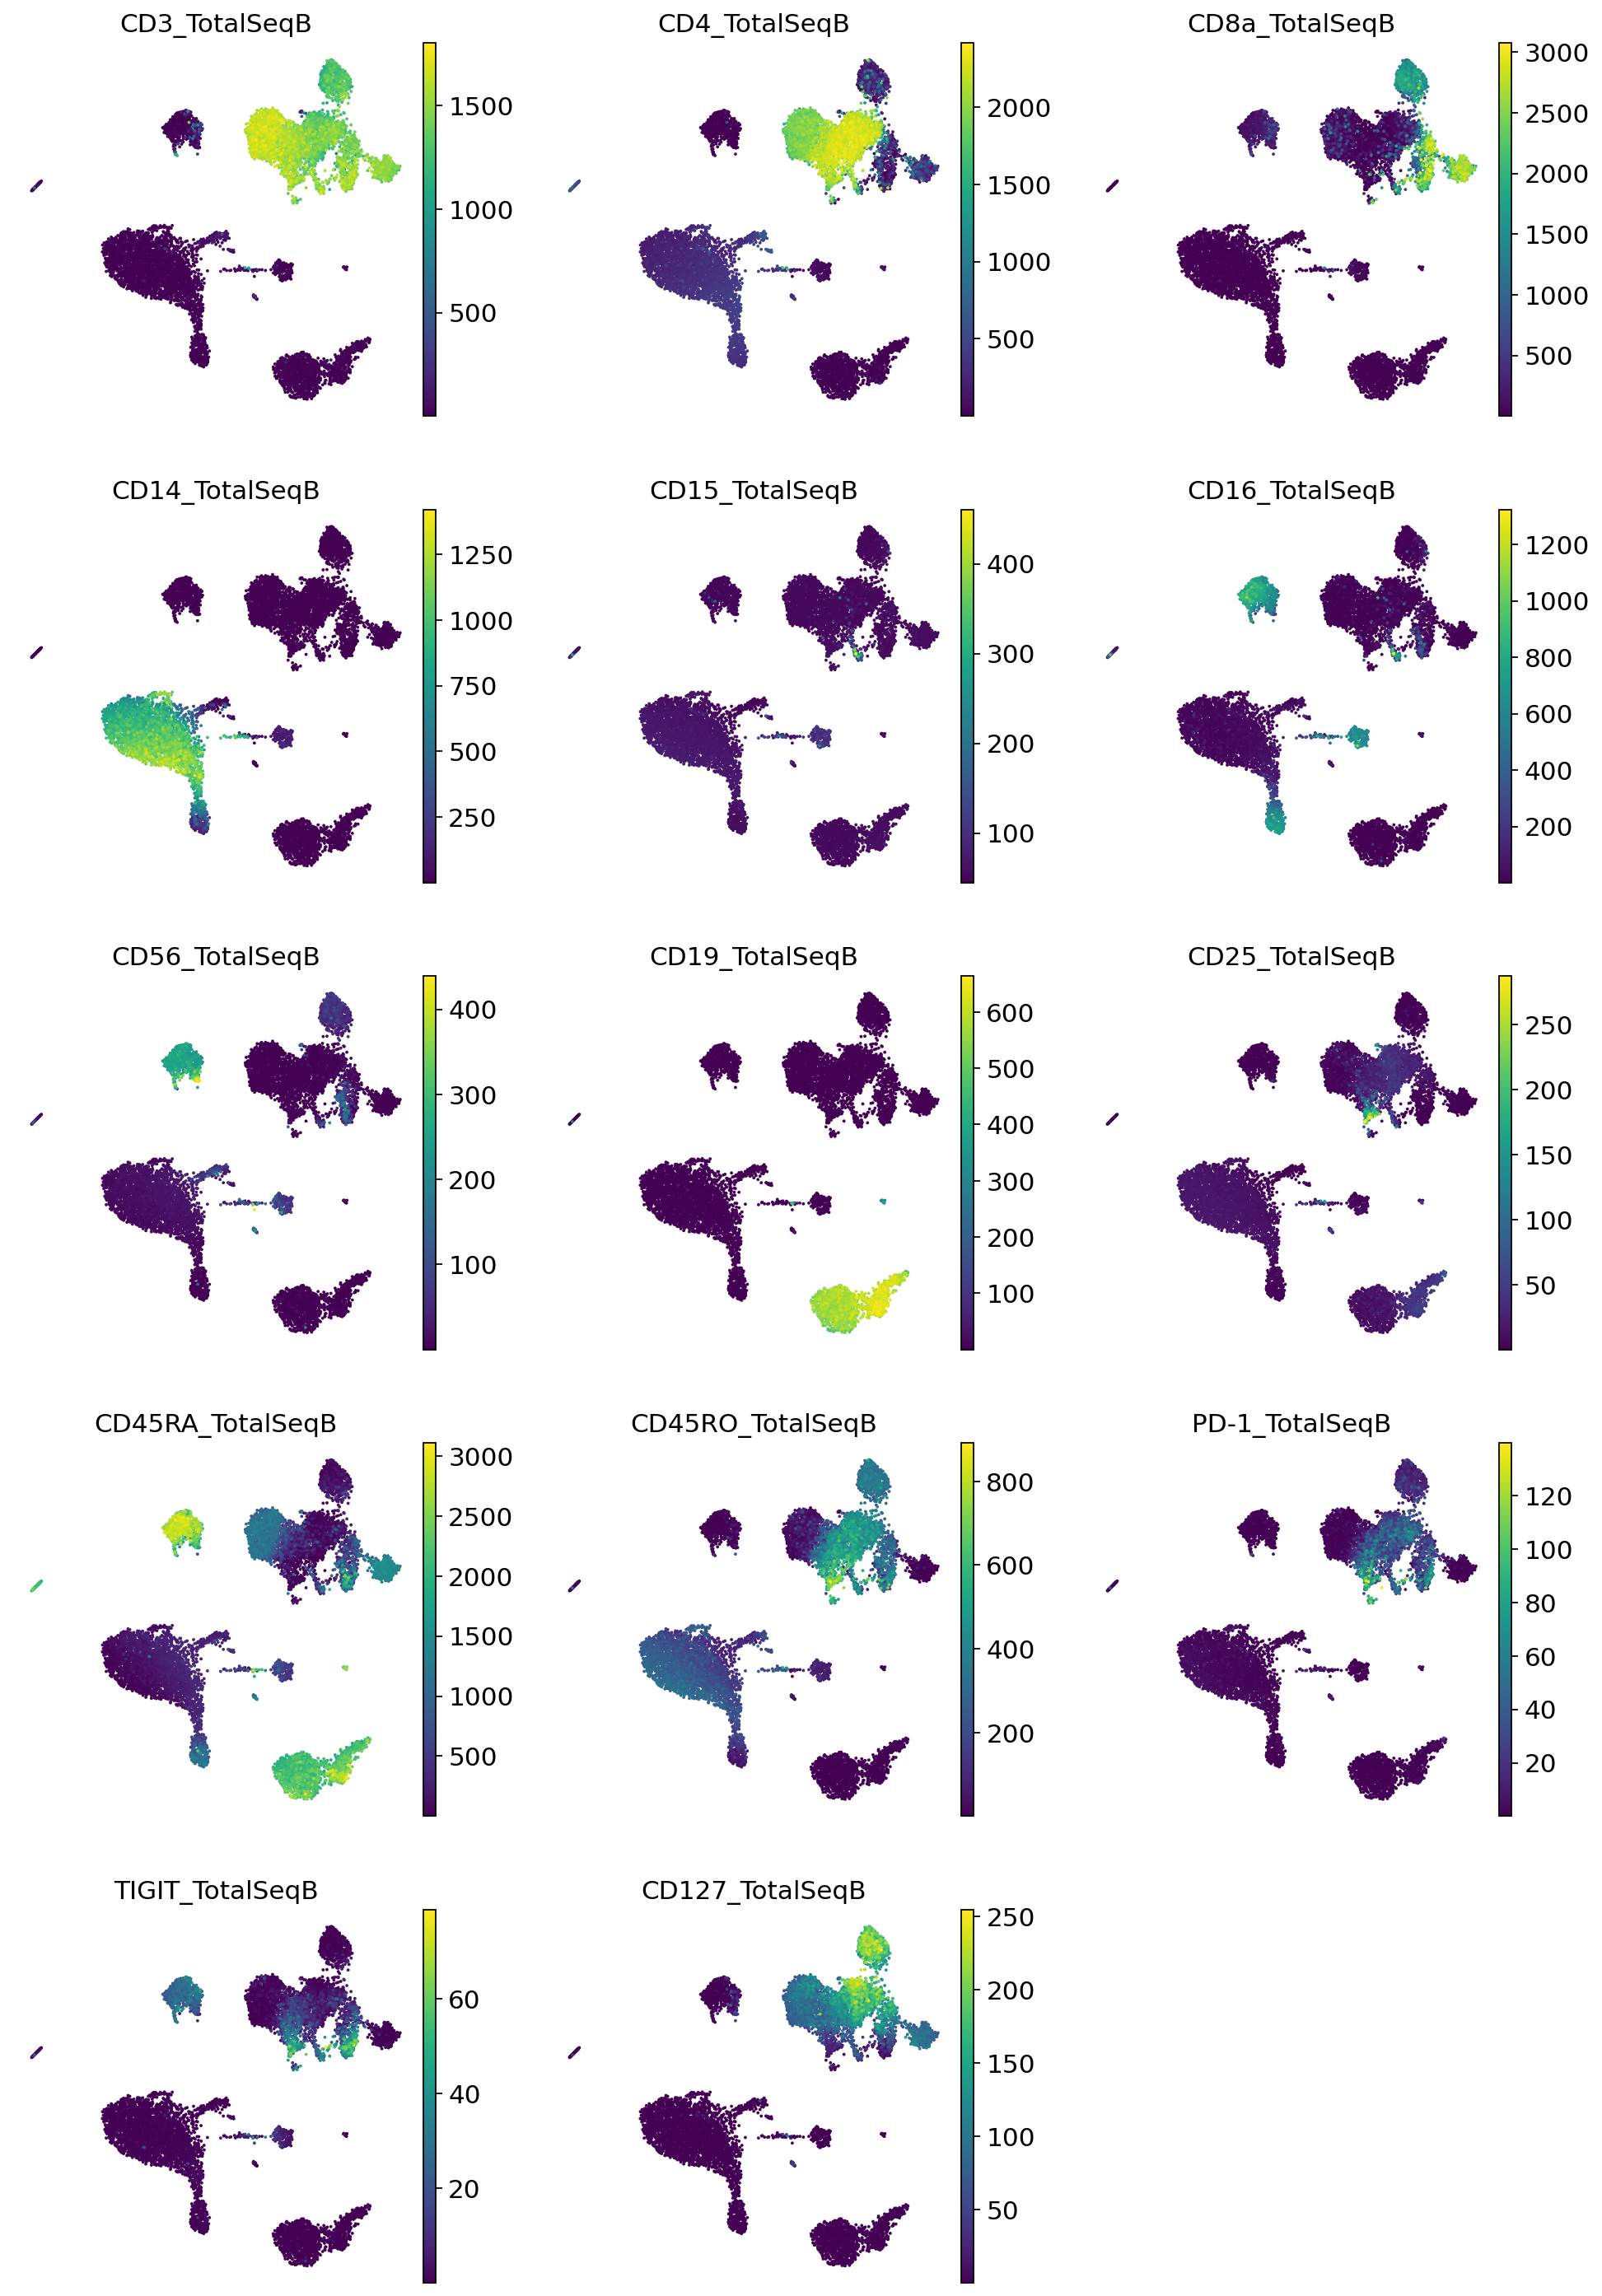

In [55]:
adata_query.obs = pd.concat([adata_query.obs, imputed_proteins], axis=1)

sc.pl.umap(
    adata_query,
    color=imputed_proteins.columns,
    frameon=False,
    ncols=3,
)

#### Visualize reference and query

In [56]:
adata_full_new = adata_query.concatenate(adata_ref, batch_key="none")

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [57]:
adata_full_new.obsm["X_totalVI"] = vae_q.get_latent_representation(adata_full_new)
sc.pp.neighbors(adata_full_new, use_rep="X_totalVI")
sc.tl.umap(adata_full_new, min_dist=0.3)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Found batches with missing protein expression                                       


/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1525: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if (hasattr(numpy, value)
/usr/local/lib/python3.7/dist-packages/numba/core/ir_utils.py:1526: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  and def_val == getattr(numpy, value)):
/usr/local/lib/python3.7/dist-packages/numba/core/ir_util

In [58]:
_, imputed_proteins_all = vae_q.get_normalized_expression(
    adata_full_new,
    n_samples=25,
    return_mean=True,
    transform_batch=["PBMC10k", "PBMC5k"],
)

for i, p in enumerate(imputed_proteins_all.columns):
    adata_full_new.obs[p] = imputed_proteins_all[p].to_numpy().copy()

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1237: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'batch' as categorical


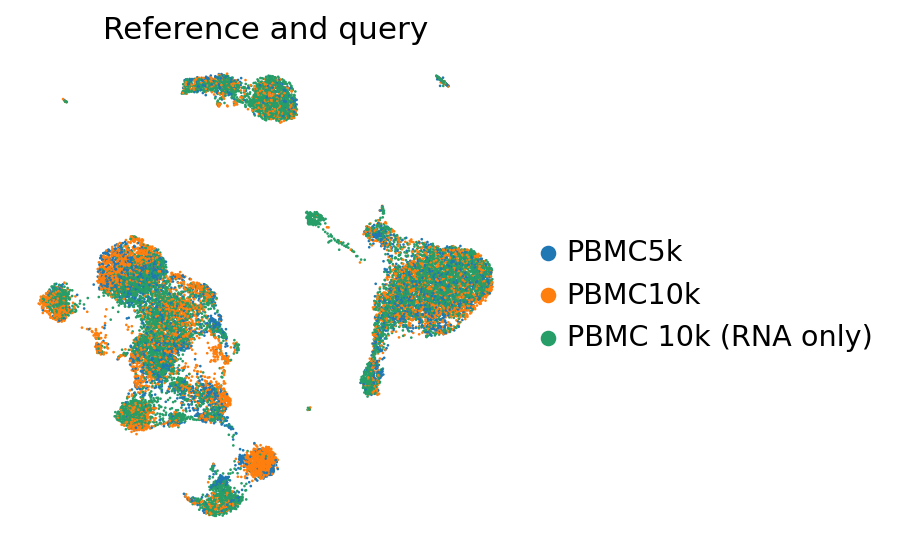

In [59]:
perm_inds = np.random.permutation(np.arange(adata_full_new.n_obs))
sc.pl.umap(
    adata_full_new[perm_inds],
    color=["batch"],
    frameon=False,
    ncols=1,
    title="Reference and query"
)

/usr/local/lib/python3.7/dist-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


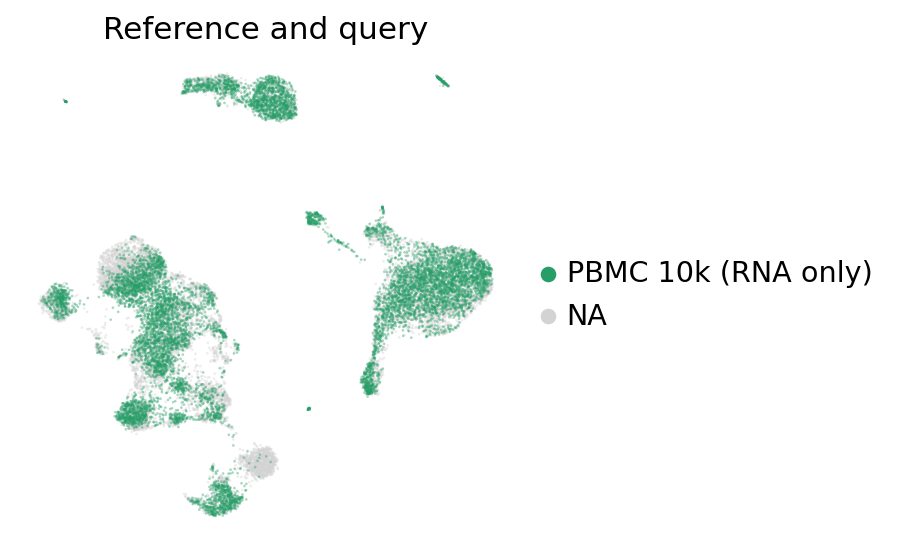

In [60]:
ax = sc.pl.umap(
    adata_full_new,
    color="batch",
    groups=["PBMC 10k (RNA only)"],
    frameon=False,
    ncols=1,
    title="Reference and query",
    alpha=0.4
)

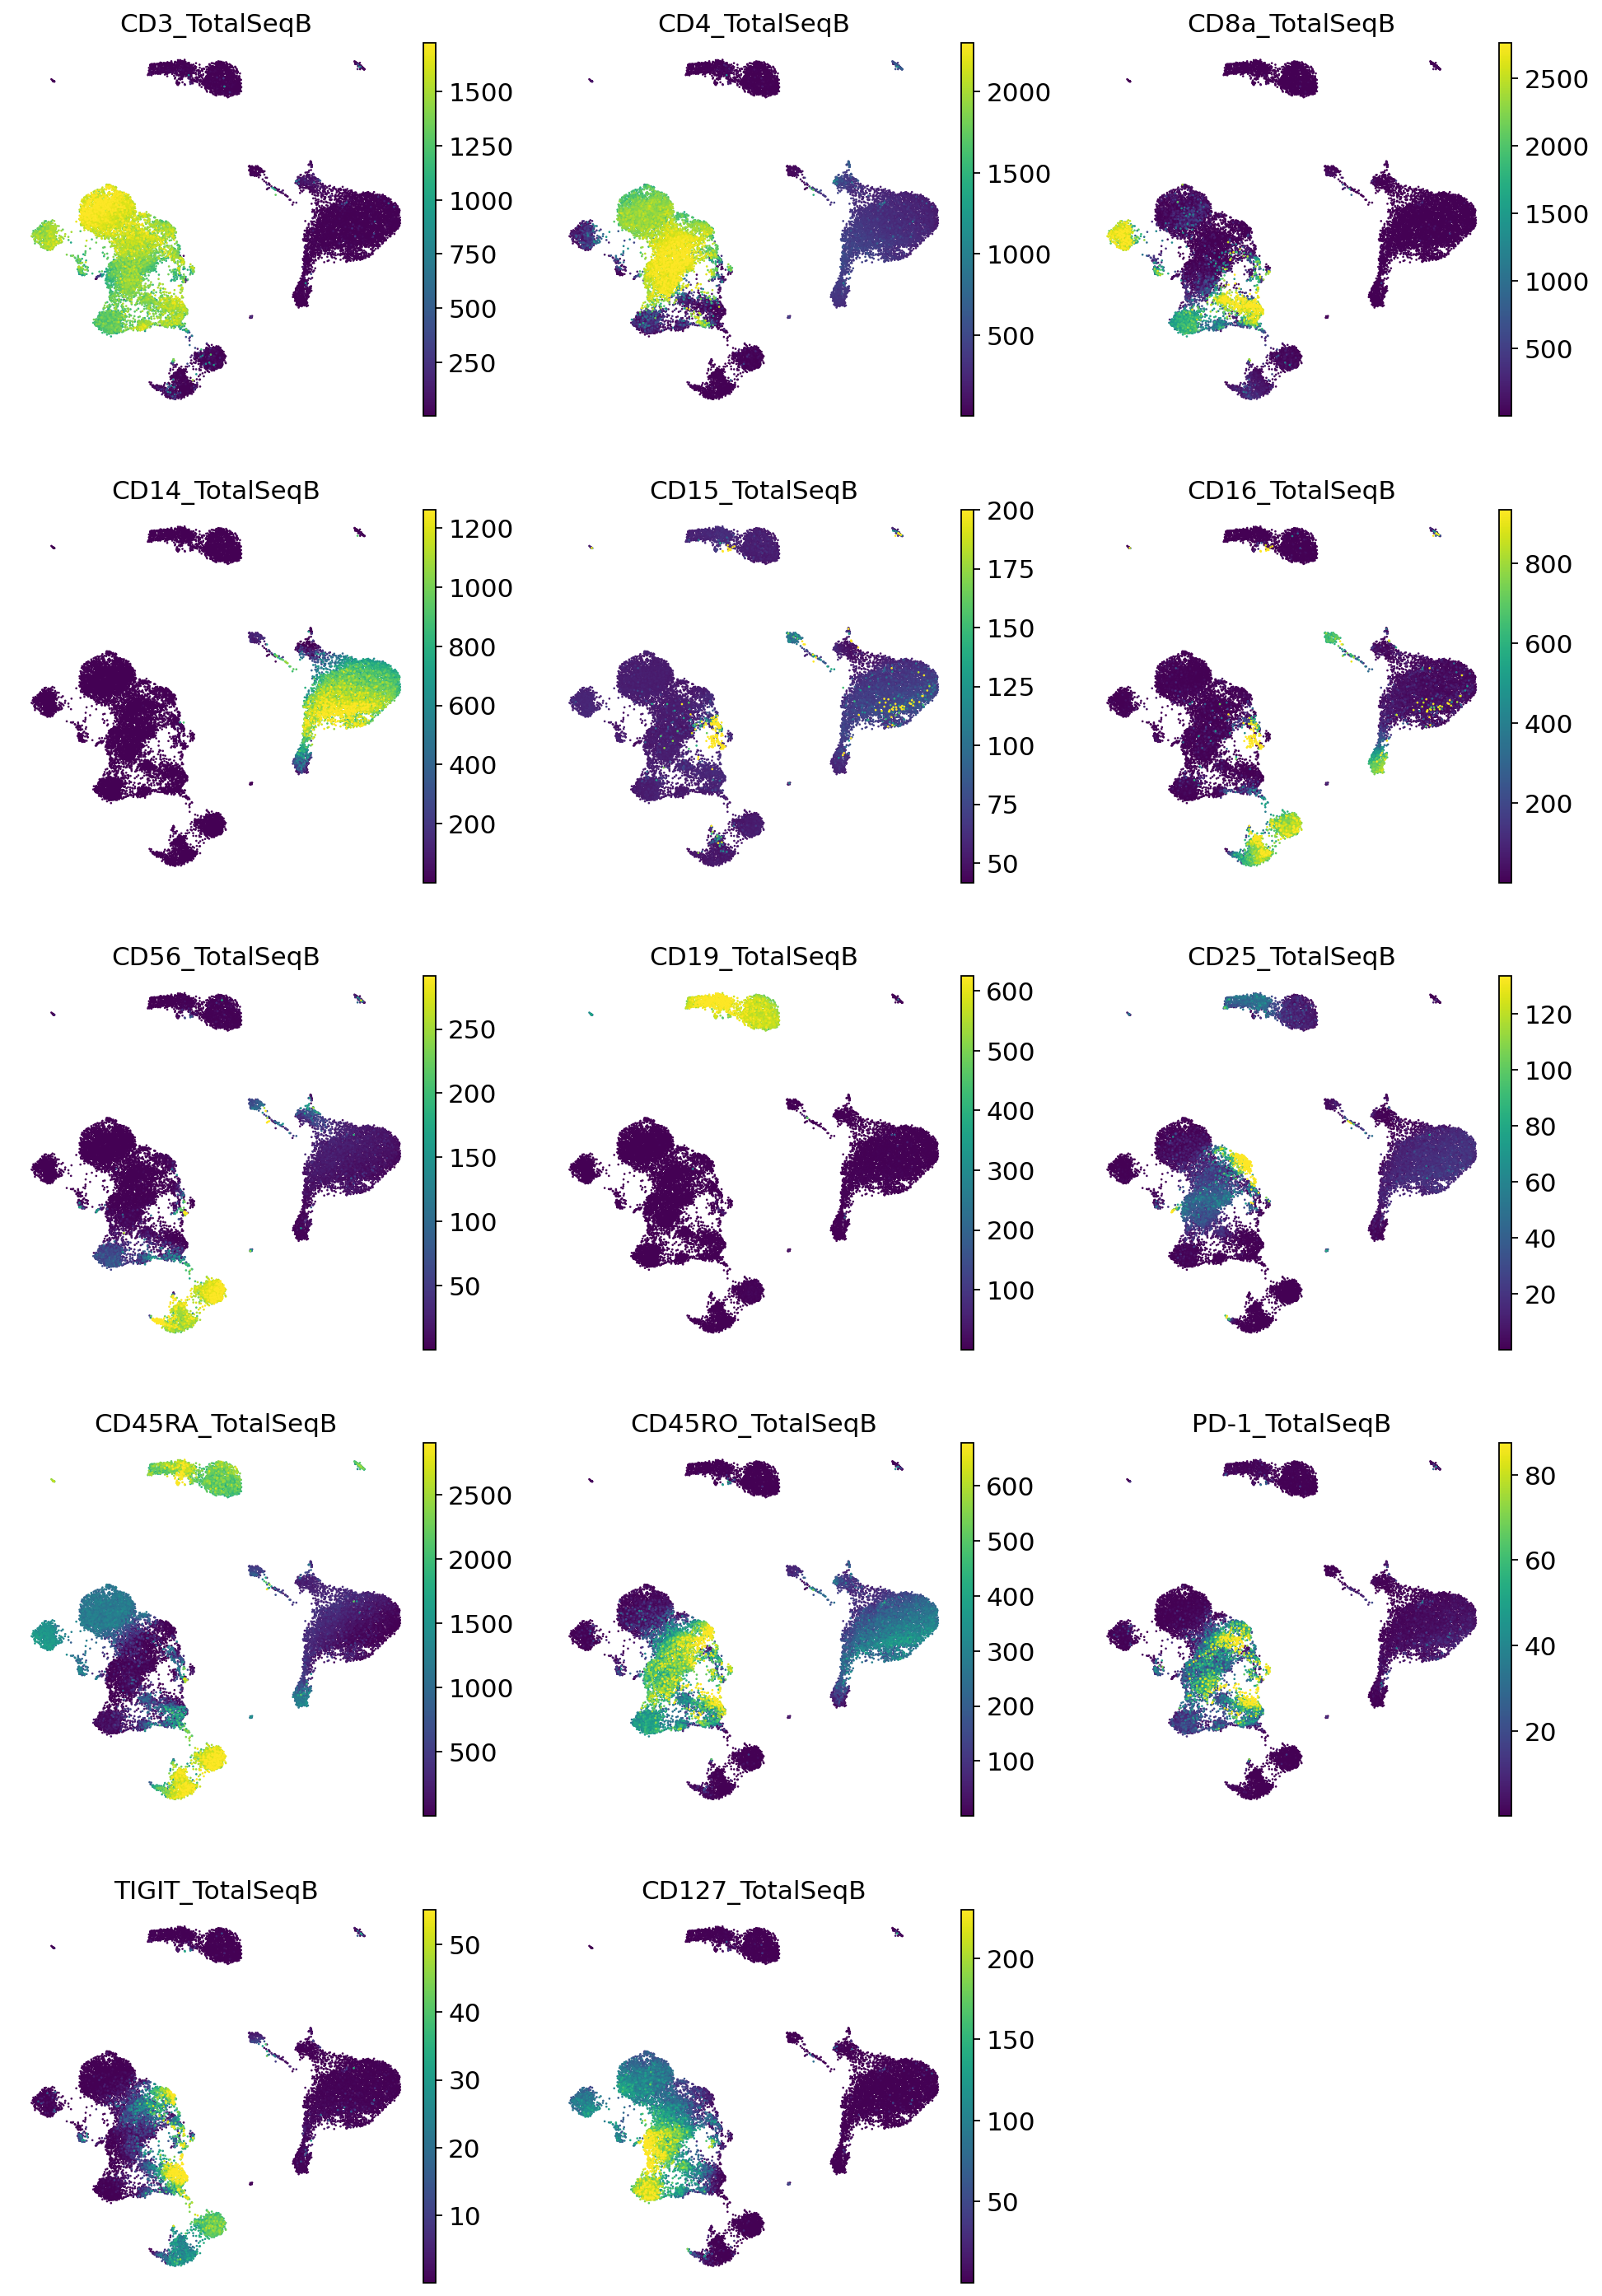

In [61]:
sc.pl.umap(
    adata_full_new,
    color=imputed_proteins_all.columns,
    frameon=False,
    ncols=3,
    vmax="p99"
)